In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import os
import time
from keras.utils import image_dataset_from_directory
tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense 
import matplotlib.pyplot as plt
import keras_cv
from randaug import RandAugment1
from fencemask import FenceMask

You do not have Waymo Open Dataset installed, so KerasCV Waymo metrics are not available.


In [2]:
def plot_history_metrics(history):
    auc = history['auc']
    val_auc = history['val_auc']
    loss = history['loss']
    val_loss = history['val_loss']
    cat_acc = history['cat_acc']
    val_cat_acc = history['val_cat_acc']
    cohen_kappa = history['cohenkappa']
    val_cohen = history['val_cohenkappa']
    sensitivity = history['sensitivity_at_specificity']
    val_sensitivity = history['val_sensitivity_at_specificity']
    specificity = history['specificity_at_sensitivity']
    val_specificity = history['val_specificity_at_sensitivity']
    qwk = history['QWK']
    val_qwk = history['val_QWK']
    f1_score = history['f1_score']
    val_f1_score = history['val_f1_score']
    epochs = range(len(auc))

    plt.figure(figsize=(18, 12))
    
    plt.subplot(3, 3, 1)
    plt.plot(epochs, auc, 'r', label='Training auc')
    plt.plot(epochs, val_auc, 'b', label='Validation auc')
    plt.ylim(0, 1)
    plt.title('Training and validation AUC')
    plt.legend(loc=0)

    plt.subplot(3, 3, 2)
    plt.plot(epochs, loss, 'y-.', label='Training loss')
    plt.plot(epochs, val_loss, 'g-.', label='Validation loss')
    plt.title('Training and validation Loss')
    plt.ylim(0, 2)
    plt.legend(loc=0)

    plt.subplot(3, 3, 3)
    plt.plot(epochs, cat_acc, 'c-.', label='Training cat_acc')
    plt.plot(epochs, val_cat_acc, 'g', label='Validation cat_acc')
    plt.title('Training and validation cat_acc')
    plt.ylim(0, 1)
    plt.legend(loc=0)

    plt.subplot(3, 3, 4)
    plt.plot(epochs, cohen_kappa, 'c-.', label='Training Cohen Kappa')
    plt.plot(epochs, val_cohen, 'g', label='Validation Cohen Kappa')
    plt.title('Training and validation Cohen Kappa')
    plt.ylim(0, 1)
    plt.legend(loc=0)

    plt.subplot(3, 3, 5)
    plt.plot(epochs, sensitivity, 'c-.', label='Training Sensitivity')
    plt.plot(epochs, val_sensitivity, 'g', label='Validation Sensitivity')
    plt.title('Training and validation Sensitivity')
    plt.ylim(0, 1)
    plt.legend(loc=0)

    plt.subplot(3, 3, 6)
    plt.plot(epochs, specificity, 'c-.', label='Training Specificity')
    plt.plot(epochs, val_specificity, 'g', label='Validation Specificity')
    plt.title('Training and validation Specificity')
    plt.ylim(0, 1)
    plt.legend(loc=0)

    plt.subplot(3, 3, 7)
    plt.plot(epochs, qwk, 'c-.', label='Training QWK')
    plt.plot(epochs, val_qwk, 'g', label='Validation QWK')
    plt.title('Training and validation QWK')
    plt.ylim(0, 1)
    plt.legend(loc=0)

    plt.subplot(3, 3, 8)
    plt.plot(epochs, f1_score, 'c-.', label='Training F1 Score')
    plt.plot(epochs, val_f1_score, 'g', label='Validation F1 Score')
    plt.title('Training and validation F1 Score')
    plt.ylim(0, 1)
    plt.legend(loc=0)

    plt.show()

In [3]:
IMG_SIZE = 400
image_dir = os.path.join('..', 'dataset','Ben processed','deepdridtrainprocessed')
train_dataset=image_dataset_from_directory(
    image_dir,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=None,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

image_dir = os.path.join('..', 'dataset','Ben processed','deepdridvalidprocessed')
valid_dataset=image_dataset_from_directory(
    image_dir,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=None,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

def prepare_sample(image, label):
        return image, tf.one_hot(label, 5)

def geometric_augmentation(image):
    # Flipping (horizontally or vertically)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    # Rotation (0-360 degrees)
    image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

    # Random cropping (90%)
    image = tf.image.random_crop(image, size=(400, 400, 3))
    return image


random_hue = keras_cv.layers.preprocessing.RandomHue(factor=0.5,value_range=[0, 255] )
random_gridmask = keras_cv.layers.preprocessing.GridMask()
rand_augment = RandAugment1(
    value_range=(0, 255),
    augmentations_per_image=3,
    magnitude=0.8,
    magnitude_stddev=0.5,
    rate=0.8,
)
augmix = keras_cv.layers.AugMix([0, 255])
fourier_mix = keras_cv.layers.preprocessing.FourierMix(0.5)
random_gridmask = keras_cv.layers.preprocessing.GridMask()
fencemask = FenceMask(ratio_factor=keras_cv.ConstantFactorSampler(0.95))
train_dataset = train_dataset.map(prepare_sample,
            num_parallel_calls=tf.data.AUTOTUNE)
valid_dataset = valid_dataset.map(prepare_sample,
            num_parallel_calls=tf.data.AUTOTUNE)

def apply_geometricaug(images, labels):
    inputs = [geometric_augmentation(images),labels]
    return inputs

def apply_randomhue(images, labels):
    inputs = [random_hue(images),labels]
    return inputs

def apply_rand_augment(images, labels):
    inputs = [rand_augment(images),labels]
    return inputs

def apply_augmix(images, labels):
    inputs = [augmix(images),labels]
    return inputs

def apply_gridmask(images, labels):
    inputs = [random_gridmask(images),labels]
    return inputs

def apply_fencemask(images, labels):
    inputs = [fencemask(images),labels]
    return inputs

geo_dataset = train_dataset.map(apply_geometricaug)
randomhue_dataset = train_dataset.map(apply_randomhue)
randaug_dataset = train_dataset.map(apply_rand_augment)
augmix_dataset = train_dataset.map(apply_augmix)
gridmask_dataset = train_dataset.map(apply_gridmask)
fencemask_dataset = train_dataset.map(apply_fencemask)
geo_dataset=geo_dataset.batch(batch_size=16)
randomhue_dataset=randomhue_dataset.batch(batch_size=16)
randaug_dataset=randaug_dataset.batch(batch_size=16)
augmix_dataset=augmix_dataset.batch(batch_size=16)
gridmask_dataset=gridmask_dataset.batch(batch_size=16)
fencemask_dataset=fencemask_dataset.batch(batch_size=16)
valid_dataset=valid_dataset.batch(batch_size=16)

Found 1200 files belonging to 5 classes.
Found 400 files belonging to 5 classes.


# normal geometric

In [8]:
input_shape=(400, 400, 3)

img_input = Input(shape=input_shape)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2M(
    include_top=False,
    weights='imagenet',
    input_tensor=img_input,
    input_shape=input_shape,
    pooling='max',
    classes=5,
    classifier_activation='softmax',
    include_preprocessing=False
)

base_model.trainable = True
x = base_model.output
predictions = Dense(5, 
                    activation="softmax", 
                    name="predictions")(x)
model = Model(inputs=img_input, 
              outputs=predictions)

num_classes = 5
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), #by default learning_rate=0.001
    loss='categorical_crossentropy',
    metrics=[tf.keras.metrics.CategoricalAccuracy(name="cat_acc"),tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.Recall(name='recall'),tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.SensitivityAtSpecificity(specificity=0.9,name='sensitivity_at_specificity'),
            tf.keras.metrics.SpecificityAtSensitivity(sensitivity=0.9,name='specificity_at_sensitivity'),
            tfa.metrics.F1Score(num_classes=num_classes,average='macro'),
            tfa.metrics.CohenKappa(num_classes=num_classes,name='cohenkappa'),
            tfa.metrics.CohenKappa(num_classes=num_classes,weightage='quadratic',name='QWK')]
            
)

model.summary()

checkpoint_path = 'weight list/effnetv2deepdridgeo_dataset.h5'
start = time.time()
history1 = model.fit(
    geo_dataset,
    epochs=50,
    #steps_per_epoch=NUM_TRAIN_IMAGES/32, los batchs de 32 ya han sido asignados arriba
    validation_data=valid_dataset,
    #validation_steps=NUM_VAL_IMAGES/32,
    shuffle=True,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=11, verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau(patience=4, verbose=1),
        tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                            save_weights_only=True,
                                            monitor='val_QWK',
                                            mode='max',
                                            save_best_only=True, verbose=1)
    ]
)
end = time.time()
duration = end - start
hours, rem = divmod(duration, 3600)
minutes, seconds = divmod(rem, 60)

print("Training time: {:0>2}:{:0>2}:{:05.2f}".format(int(hours), int(minutes), seconds))

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 400, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 200, 200, 24  648         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 200, 200, 24  96          ['stem_conv[0][0]']              
                                )                                                           

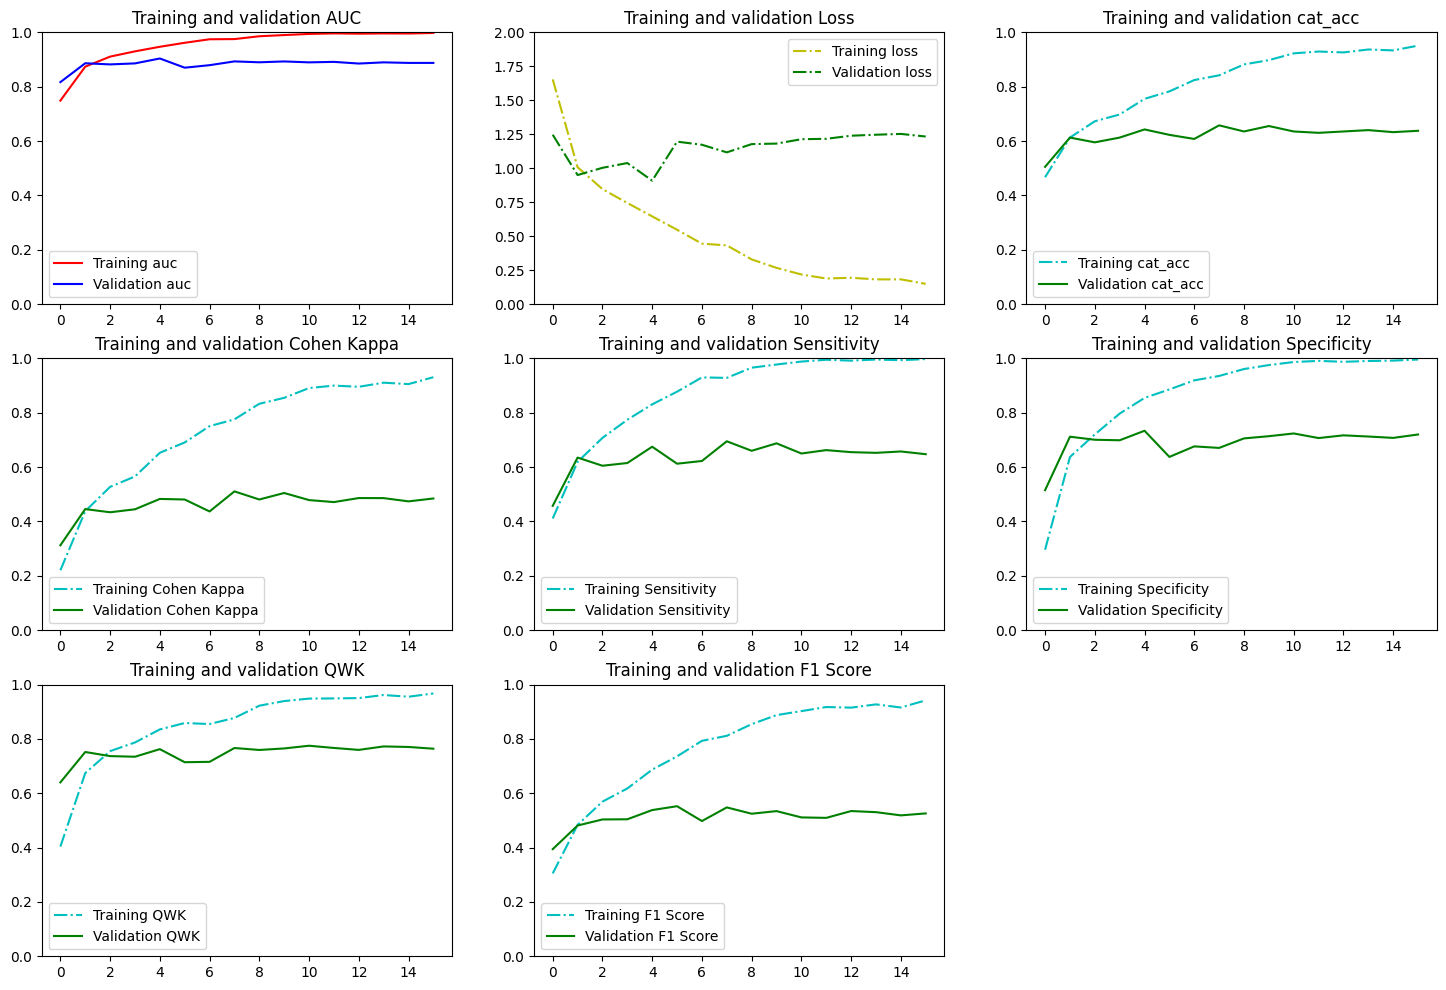

In [9]:
# Convert the history object to a DataFrame
history_df = pd.DataFrame(history1.history)

# Save the DataFrame to a CSV file
history_df.to_csv('effnetv2deepdridgeo_dataset.csv', index=False)
plot_history_metrics(history1.history)

# randaug

In [10]:
input_shape=(400, 400, 3)

img_input = Input(shape=input_shape)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2M(
    include_top=False,
    weights='imagenet',
    input_tensor=img_input,
    input_shape=input_shape,
    pooling='max',
    classes=5,
    classifier_activation='softmax',
    include_preprocessing=False
)

base_model.trainable = True
x = base_model.output
predictions = Dense(5, 
                    activation="softmax", 
                    name="predictions")(x)
model = Model(inputs=img_input, 
              outputs=predictions)

num_classes = 5
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), #by default learning_rate=0.001
    loss='categorical_crossentropy',
    metrics=[tf.keras.metrics.CategoricalAccuracy(name="cat_acc"),tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.Recall(name='recall'),tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.SensitivityAtSpecificity(specificity=0.9,name='sensitivity_at_specificity'),
            tf.keras.metrics.SpecificityAtSensitivity(sensitivity=0.9,name='specificity_at_sensitivity'),
            tfa.metrics.F1Score(num_classes=num_classes,average='macro'),
            tfa.metrics.CohenKappa(num_classes=num_classes,name='cohenkappa'),
            tfa.metrics.CohenKappa(num_classes=num_classes,weightage='quadratic',name='QWK')]
            
)

model.summary()

checkpoint_path = 'weight list/effnetv2deepdridrandaug.h5'
start = time.time()
history2 = model.fit(
    randaug_dataset,
    epochs=50,
    #steps_per_epoch=NUM_TRAIN_IMAGES/32, los batchs de 32 ya han sido asignados arriba
    validation_data=valid_dataset,
    #validation_steps=NUM_VAL_IMAGES/32,
    shuffle=True,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=11, verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau(patience=4, verbose=1),
        tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                            save_weights_only=True,
                                            monitor='val_QWK',
                                            mode='max',
                                            save_best_only=True, verbose=1)
    ]
)
end = time.time()
duration = end - start
hours, rem = divmod(duration, 3600)
minutes, seconds = divmod(rem, 60)

print("Training time: {:0>2}:{:0>2}:{:05.2f}".format(int(hours), int(minutes), seconds))

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 400, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 200, 200, 24  648         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 200, 200, 24  96          ['stem_conv[0][0]']              
                                )                                                           

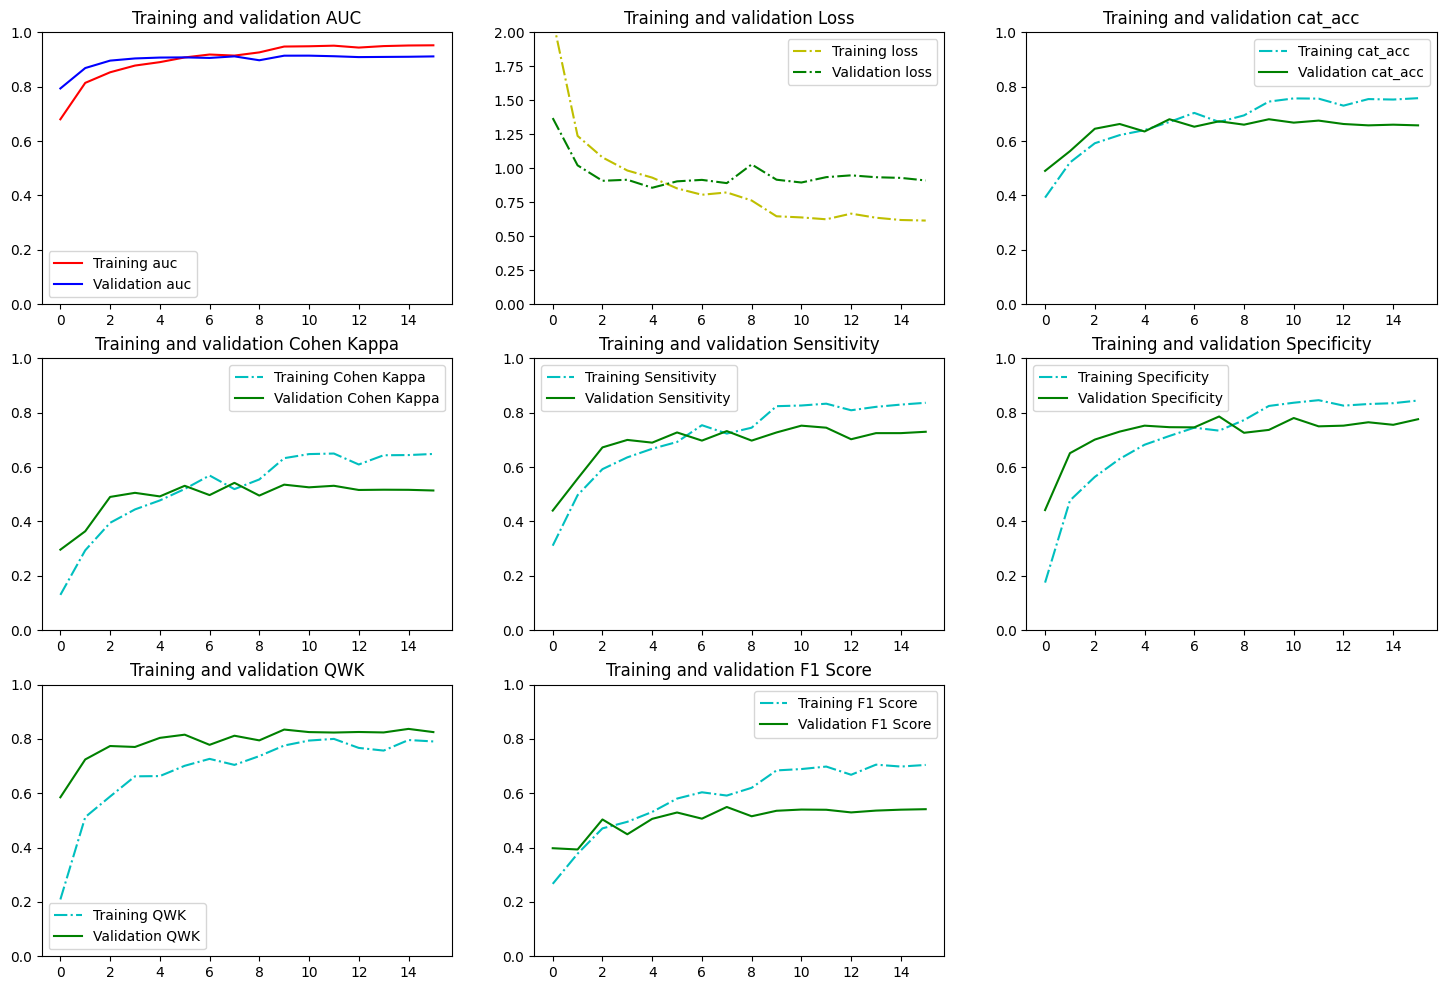

In [11]:
# Convert the history object to a DataFrame
history_df = pd.DataFrame(history2.history)

# Save the DataFrame to a CSV file
history_df.to_csv('effnetv2deepdridrandaug.csv', index=False)
plot_history_metrics(history2.history)

# augmix

In [12]:
input_shape=(400, 400, 3)

img_input = Input(shape=input_shape)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2M(
    include_top=False,
    weights='imagenet',
    input_tensor=img_input,
    input_shape=input_shape,
    pooling='max',
    classes=5,
    classifier_activation='softmax',
    include_preprocessing=False
)

base_model.trainable = True
x = base_model.output
predictions = Dense(5, 
                    activation="softmax", 
                    name="predictions")(x)
model = Model(inputs=img_input, 
              outputs=predictions)

num_classes = 5
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), #by default learning_rate=0.001
    loss='categorical_crossentropy',
    metrics=[tf.keras.metrics.CategoricalAccuracy(name="cat_acc"),tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.Recall(name='recall'),tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.SensitivityAtSpecificity(specificity=0.9,name='sensitivity_at_specificity'),
            tf.keras.metrics.SpecificityAtSensitivity(sensitivity=0.9,name='specificity_at_sensitivity'),
            tfa.metrics.F1Score(num_classes=num_classes,average='macro'),
            tfa.metrics.CohenKappa(num_classes=num_classes,name='cohenkappa'),
            tfa.metrics.CohenKappa(num_classes=num_classes,weightage='quadratic',name='QWK')]
            
)

model.summary()

checkpoint_path = 'weight list/effnetv2deepdridaugmix.h5'
start = time.time()
history3 = model.fit(
    augmix_dataset,
    epochs=50,
    #steps_per_epoch=NUM_TRAIN_IMAGES/32, los batchs de 32 ya han sido asignados arriba
    validation_data=valid_dataset,
    #validation_steps=NUM_VAL_IMAGES/32,
    shuffle=True,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=11, verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau(patience=4, verbose=1),
        tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                            save_weights_only=True,
                                            monitor='val_QWK',
                                            mode='max',
                                            save_best_only=True, verbose=1)
    ]
)
end = time.time()
duration = end - start
hours, rem = divmod(duration, 3600)
minutes, seconds = divmod(rem, 60)

print("Training time: {:0>2}:{:0>2}:{:05.2f}".format(int(hours), int(minutes), seconds))

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 400, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 200, 200, 24  648         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 200, 200, 24  96          ['stem_conv[0][0]']              
                                )                                                           

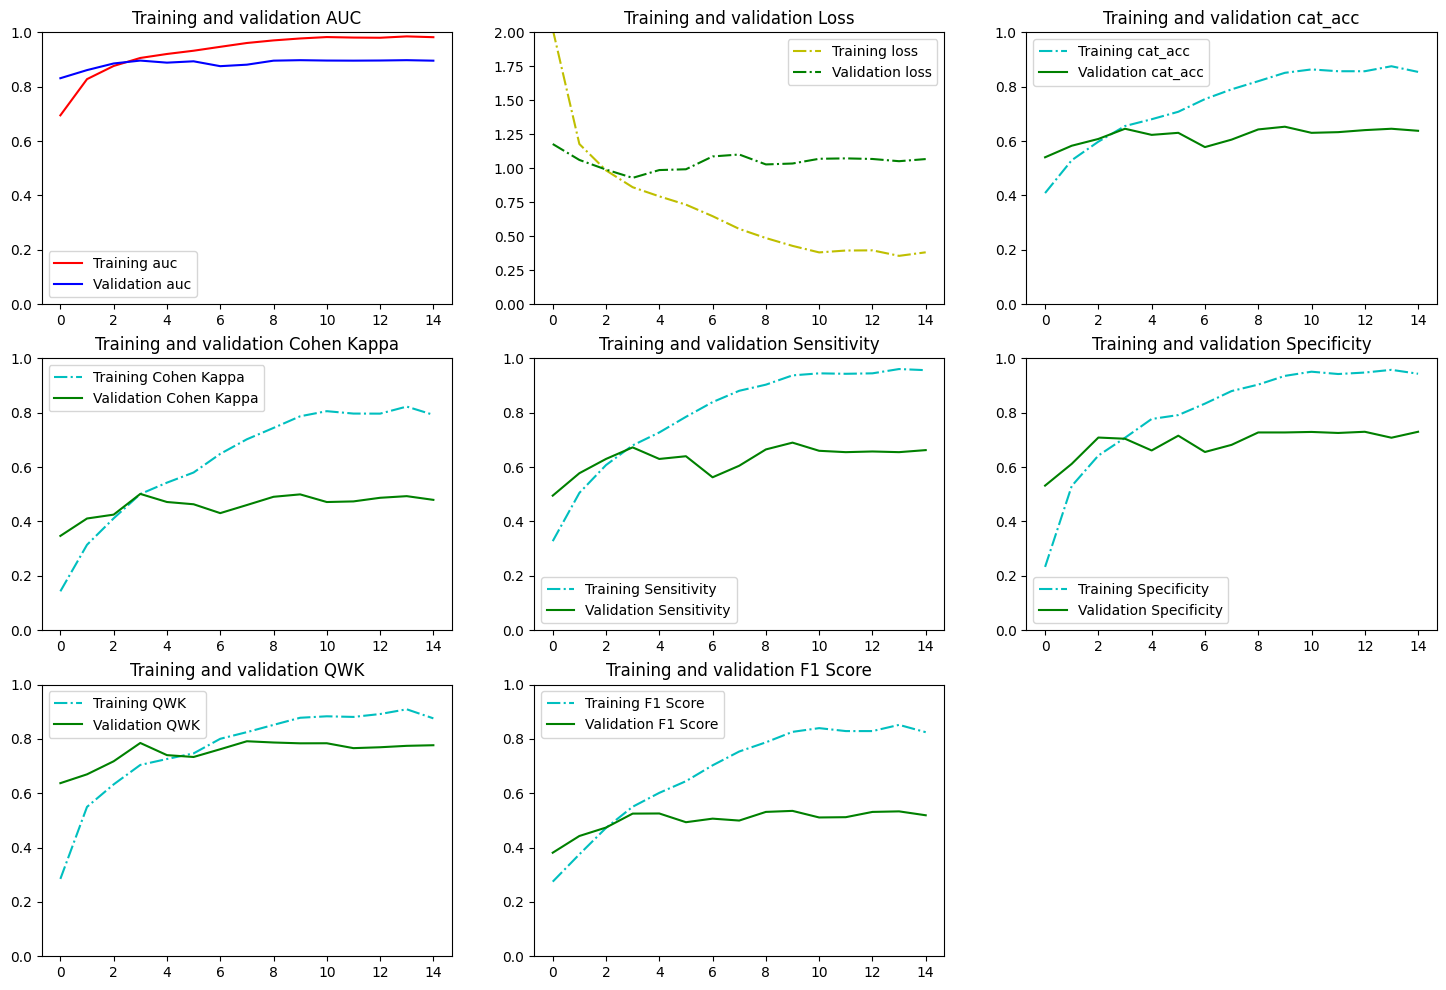

In [13]:
# Convert the history object to a DataFrame
history_df = pd.DataFrame(history3.history)

# Save the DataFrame to a CSV file
history_df.to_csv('effnetv2deepdridaugmix.csv', index=False)
plot_history_metrics(history3.history)

# gridmask

In [14]:
input_shape=(400, 400, 3)

img_input = Input(shape=input_shape)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2M(
    include_top=False,
    weights='imagenet',
    input_tensor=img_input,
    input_shape=input_shape,
    pooling='max',
    classes=5,
    classifier_activation='softmax',
    include_preprocessing=False
)

base_model.trainable = True
x = base_model.output
predictions = Dense(5, 
                    activation="softmax", 
                    name="predictions")(x)
model = Model(inputs=img_input, 
              outputs=predictions)

num_classes = 5
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), #by default learning_rate=0.001
    loss='categorical_crossentropy',
    metrics=[tf.keras.metrics.CategoricalAccuracy(name="cat_acc"),tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.Recall(name='recall'),tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.SensitivityAtSpecificity(specificity=0.9,name='sensitivity_at_specificity'),
            tf.keras.metrics.SpecificityAtSensitivity(sensitivity=0.9,name='specificity_at_sensitivity'),
            tfa.metrics.F1Score(num_classes=num_classes,average='macro'),
            tfa.metrics.CohenKappa(num_classes=num_classes,name='cohenkappa'),
            tfa.metrics.CohenKappa(num_classes=num_classes,weightage='quadratic',name='QWK')]
            
)

model.summary()

checkpoint_path = 'weight list/effnetv2deepdridgridmask.h5'
start = time.time()
history4 = model.fit(
    gridmask_dataset,
    epochs=50,
    #steps_per_epoch=NUM_TRAIN_IMAGES/32, los batchs de 32 ya han sido asignados arriba
    validation_data=valid_dataset,
    #validation_steps=NUM_VAL_IMAGES/32,
    shuffle=True,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=11, verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau(patience=4, verbose=1),
        tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                            save_weights_only=True,
                                            monitor='val_QWK',
                                            mode='max',
                                            save_best_only=True, verbose=1)
    ]
)
end = time.time()
duration = end - start
hours, rem = divmod(duration, 3600)
minutes, seconds = divmod(rem, 60)

print("Training time: {:0>2}:{:0>2}:{:05.2f}".format(int(hours), int(minutes), seconds))

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 400, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 200, 200, 24  648         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 200, 200, 24  96          ['stem_conv[0][0]']              
                                )                                                           

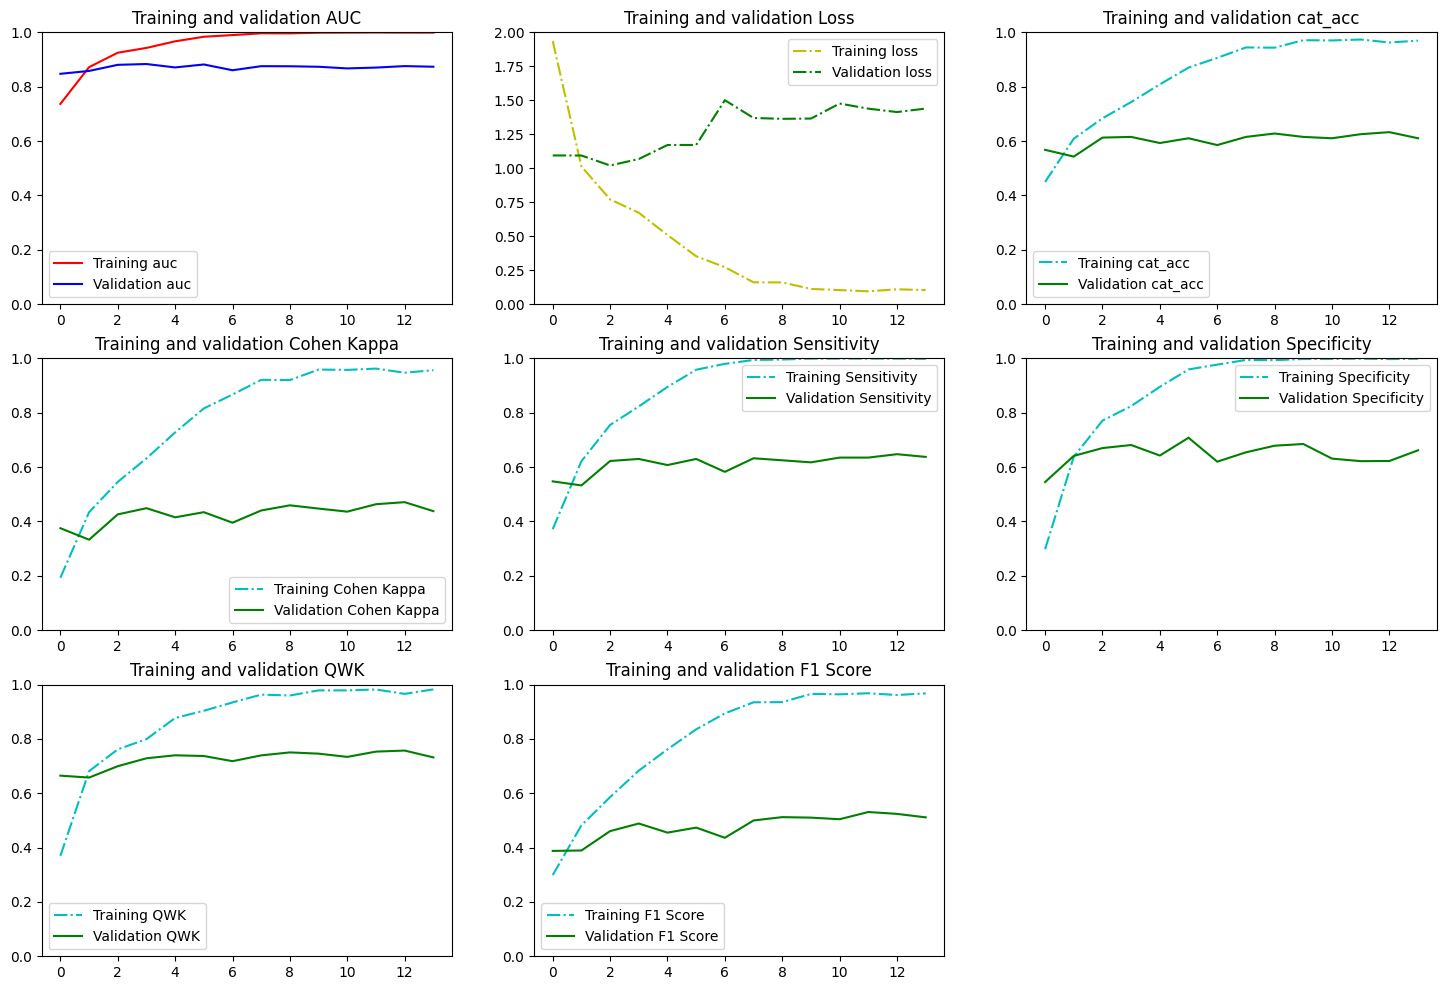

In [15]:
# Convert the history object to a DataFrame
history_df = pd.DataFrame(history4.history)

# Save the DataFrame to a CSV file
history_df.to_csv('effnetv2deepdridgridmask.csv', index=False)
plot_history_metrics(history4.history)

# Fencemask

In [4]:
input_shape=(400, 400, 3)

img_input = Input(shape=input_shape)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2M(
    include_top=False,
    weights='imagenet',
    input_tensor=img_input,
    input_shape=input_shape,
    pooling='max',
    classes=5,
    classifier_activation='softmax',
    include_preprocessing=False
)

base_model.trainable = True
x = base_model.output
predictions = Dense(5, 
                    activation="softmax", 
                    name="predictions")(x)
model = Model(inputs=img_input, 
              outputs=predictions)

num_classes = 5
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), #by default learning_rate=0.001
    loss='categorical_crossentropy',
    metrics=[tf.keras.metrics.CategoricalAccuracy(name="cat_acc"),tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.Recall(name='recall'),tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.SensitivityAtSpecificity(specificity=0.9,name='sensitivity_at_specificity'),
            tf.keras.metrics.SpecificityAtSensitivity(sensitivity=0.9,name='specificity_at_sensitivity'),
            tfa.metrics.F1Score(num_classes=num_classes,average='macro'),
            tfa.metrics.CohenKappa(num_classes=num_classes,name='cohenkappa'),
            tfa.metrics.CohenKappa(num_classes=num_classes,weightage='quadratic',name='QWK')]
            
)

model.summary()

checkpoint_path = 'weight list/effnetv2deepdridfencemask.h5'
start = time.time()
history5 = model.fit(
    fencemask_dataset,
    epochs=50,
    #steps_per_epoch=NUM_TRAIN_IMAGES/32, los batchs de 32 ya han sido asignados arriba
    validation_data=valid_dataset,
    #validation_steps=NUM_VAL_IMAGES/32,
    shuffle=True,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=11, verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau(patience=4, verbose=1),
        tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                            save_weights_only=True,
                                            monitor='val_QWK',
                                            mode='max',
                                            save_best_only=True, verbose=1)
    ]
)
end = time.time()
duration = end - start
hours, rem = divmod(duration, 3600)
minutes, seconds = divmod(rem, 60)

print("Training time: {:0>2}:{:0>2}:{:05.2f}".format(int(hours), int(minutes), seconds))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 400, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 200, 200, 24  648         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 200, 200, 24  96          ['stem_conv[0][0]']              
                                )                                                             

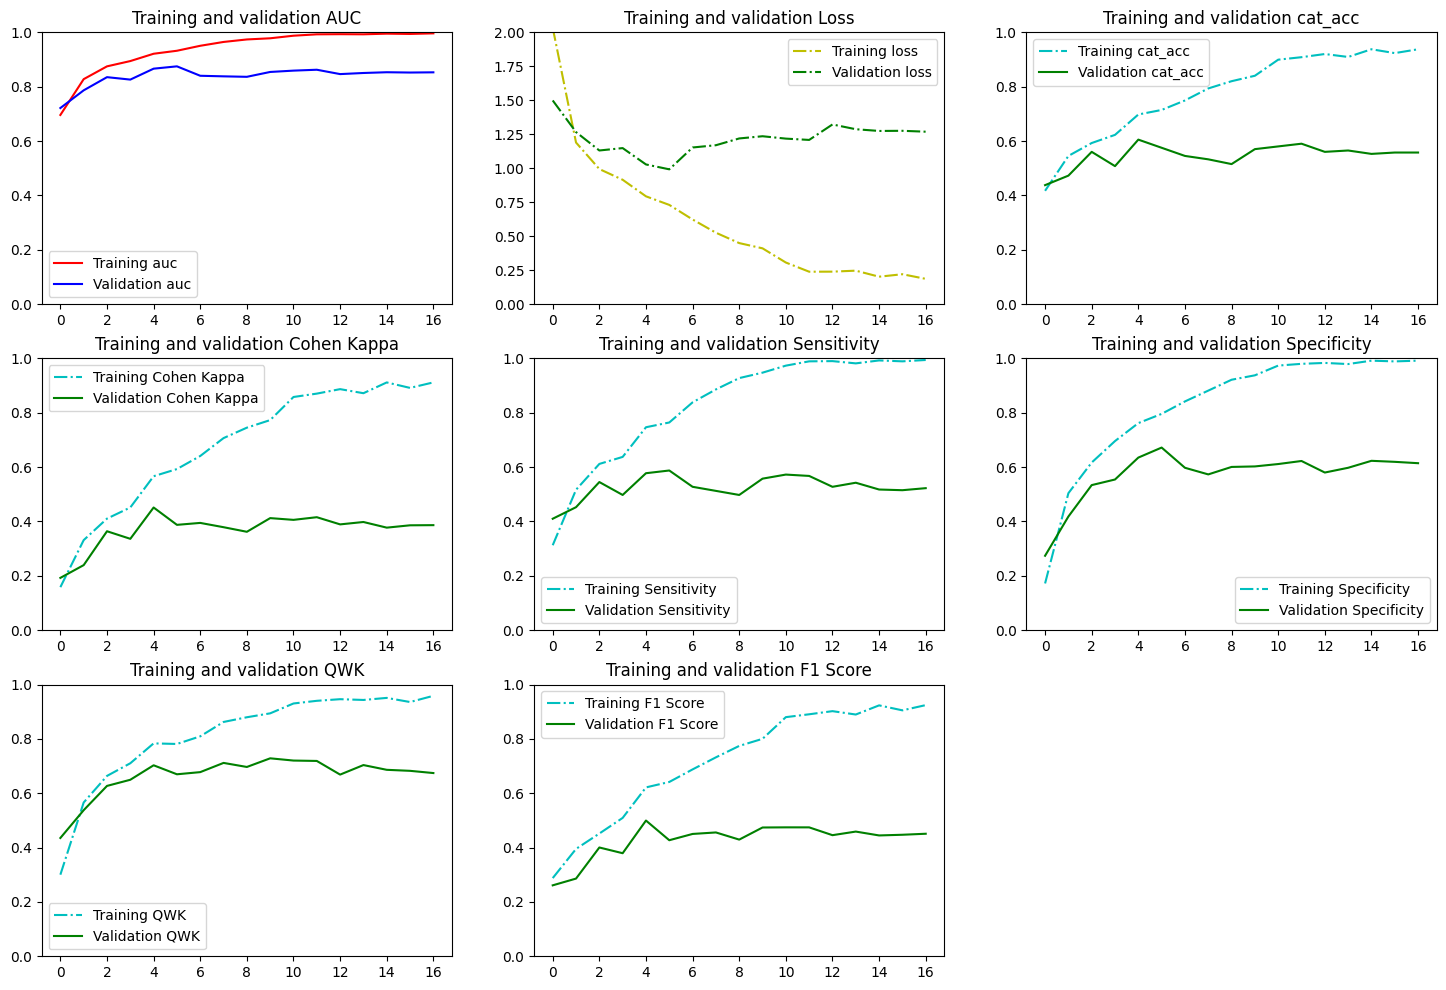

In [5]:
# Convert the history object to a DataFrame
history_df = pd.DataFrame(history5.history)

# Save the DataFrame to a CSV file
history_df.to_csv('effnetv2deepdridfencemask.csv', index=False)
plot_history_metrics(history5.history)